### Pre-process step 4
- Extract behavior events from json file saved with bonsai
- Align behavior events to fiber photometry data from step 3
- Extract rewarded and unrewarded trials and other interesting parameters

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import h5py
import json

Paths are for dataset tagged: all


In [2]:
# Load and parse json file
jsonfiles = glob.glob(os.path.join(paths['raw_data'],'*.json'))
print(jsonfiles)

behavior_jsonfile = jsonfiles[2]
with open(behavior_jsonfile) as f:
    data = json.load(f)
    print(data.keys())

['C:\\AIND\\output_data\\BigTiffs2023-07-26T14_43_04.0635264-07_00\\hsfp_rig.json', 'C:\\AIND\\output_data\\BigTiffs2023-07-26T14_43_04.0635264-07_00\\ophys_session.json', 'C:\\AIND\\output_data\\BigTiffs2023-07-26T14_43_04.0635264-07_00\\SS_683633_2023-07-26.json']
dict_keys(['TP_', 'TP_AdvancedBlockAuto', 'TP_AnimalName', 'TP_AutoReward', 'TP_AutoWaterType', 'TP_BaseRewardSum', 'TP_BiasCheck', 'TP_BlockBeta', 'TP_BlockMax', 'TP_BlockMin', 'TP_BlockMinReward', 'TP_Clear', 'TP_ConditionP_1', 'TP_ConditionP_2', 'TP_ConditionP_3', 'TP_ConditionP_4', 'TP_Condition_1', 'TP_Condition_2', 'TP_Condition_3', 'TP_Condition_4', 'TP_DelayBeta', 'TP_DelayMax', 'TP_DelayMin', 'TP_Duration_1', 'TP_Duration_2', 'TP_Duration_3', 'TP_Duration_4', 'TP_EarlyLickPulishment', 'TP_Experimenter', 'TP_ExtraWater', 'TP_Frequency_1', 'TP_Frequency_2', 'TP_Frequency_3', 'TP_Frequency_4', 'TP_GiveLeft', 'TP_GiveRight', 'TP_GiveWaterL', 'TP_GiveWaterR', 'TP_ID', 'TP_ITIBeta', 'TP_ITIIncrease', 'TP_ITIMax', 'TP_ITI

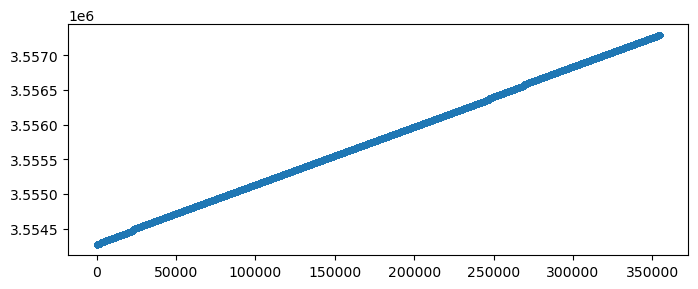

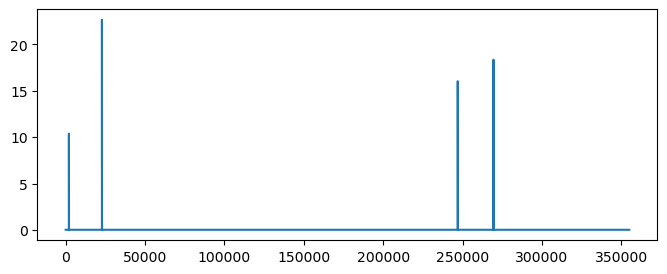

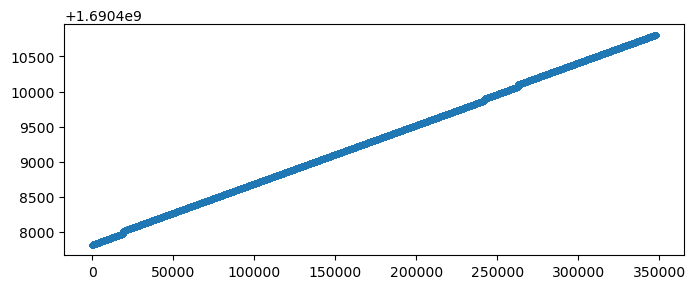

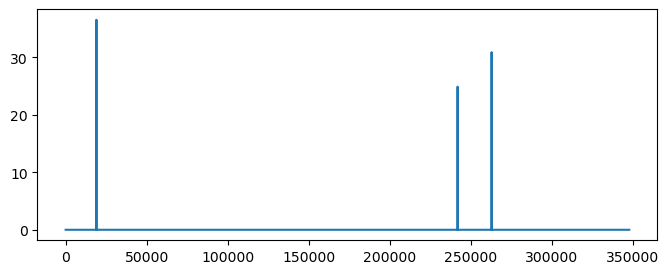

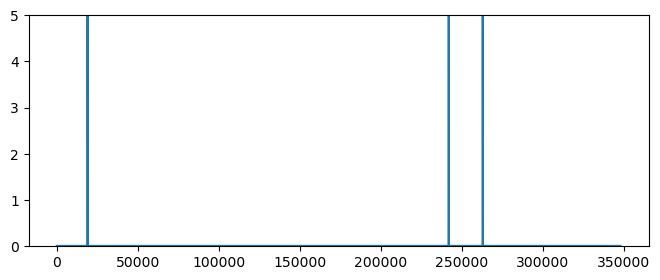

In [3]:
# Plot harp camera trigger
harp_camTrigger = data['B_CamerasTrigger']
# Plot figure with camTrigger 
plt.figure(figsize=(8,3))
plt.plot(harp_camTrigger,'.')
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(harp_camTrigger))
plt.show()

# Load HSFP preprocessed hdf5 file 
f = h5py.File(paths['raw_data'] / 'hsfp_data_preprocessed.hdf5','r')
time_405 = np.array(f['Time_405'])
time_445 = np.array(f['Time_445'])
time_473 = np.array(f['Time_473'])
time_514 = np.array(f['Time_514'])
time_560 = np.array(f['Time_560'])
timestamps = np.array(f['Full_TimeStamps'])
lasers = np.array(f['Lasers'])
wavelength = np.array(f['Wavelength'])
L_405_F1 = np.array(f['Channel_405_F1'])
L_405_F2 = np.array(f['Channel_405_F2'])
L_445_F1 = np.array(f['Channel_445_F1'])
L_445_F2 = np.array(f['Channel_445_F2'])
L_473_F1 = np.array(f['Channel_473_F1'])
L_473_F2 = np.array(f['Channel_473_F2'])
L_514_F1 = np.array(f['Channel_514_F1'])
L_514_F2 = np.array(f['Channel_514_F2'])
L_560_F1 = np.array(f['Channel_560_F1'])
L_560_F2 = np.array(f['Channel_560_F2'])
# Plot figure with camTrigger 
plt.figure(figsize=(8,3))
plt.plot(timestamps,'.')
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(timestamps))
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(timestamps))
plt.ylim(0,5)
plt.show()

In [10]:
# Make hsfp camera time and harp camera time on the same scale

# Find splits in harp camera trigger
peaks, _ = find_peaks(np.diff(harp_camTrigger), height=5)
peaks = peaks + 1
print(len(peaks))
print(peaks)

harp_times_cut = []
harp_times_cut.append(harp_camTrigger[0:peaks[0]])
for i in range(len(peaks)):
    if i == len(peaks)-1:
        harp_times_cut.append(harp_camTrigger[peaks[i]:-1])
    else:
        harp_times_cut.append(harp_camTrigger[peaks[i]:peaks[i+1]])
    
print(len(harp_times_cut))
print(len(harp_times_cut[0]))

# Find splits in hsfp camera time
peaks_hsfp, _ = find_peaks(np.diff(timestamps), height=5)
peaks_hsfp = peaks_hsfp + 1
print((peaks_hsfp))

hsfp_times_cut = []
hsfp_times_cut.append(timestamps[0:peaks_hsfp[0]])
for i in range(len(peaks_hsfp)):
    if i == len(peaks_hsfp)-1:
        hsfp_times_cut.append(timestamps[peaks_hsfp[i]:len(timestamps)])
    else:
        hsfp_times_cut.append(timestamps[peaks_hsfp[i]:peaks_hsfp[i+1]])

print(len(hsfp_times_cut))
print(len(hsfp_times_cut[0]))


4
[  2050  22850 246950 269450]
5
2050
[ 19000 242000 263000]
4
19000


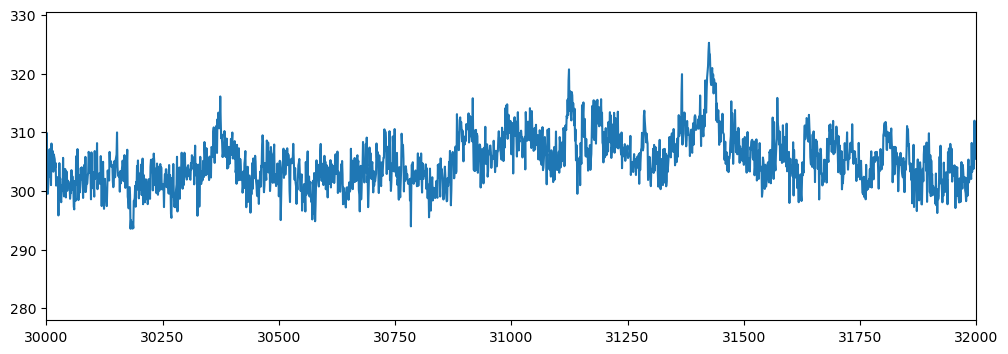

In [8]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.plot(L_445_F2[:,540-400])
plt.xlim([30000, 32000])
plt.show()

In [11]:
harp_times = []
hsfp_times = []
for i in range(len(hsfp_times_cut)):
    harp_times.append(harp_times_cut[i][0:len(hsfp_times_cut[i])])
    hsfp_times.append(hsfp_times_cut[i])

print(len(harp_times[0]))
print(len(hsfp_times[0]))

full_harp_time = np.concatenate(harp_times)
full_hsfp_time = np.concatenate(hsfp_times)

# Assign harp time to hsfp data
harp_time_405 = np.zeros(len(time_405))
harp_time_445 = np.zeros(len(time_445))
harp_time_473 = np.zeros(len(time_473))
harp_time_514 = np.zeros(len(time_514))
harp_time_560 = np.zeros(len(time_560))
for i in range(len(time_405)):
    idx = np.where(time_405[i] == full_hsfp_time)
    harp_time_405[i] = full_harp_time[idx]
for i in range(len(time_445)):
    idx = np.where(time_445[i] == full_hsfp_time)
    harp_time_445[i] = full_harp_time[idx]
for i in range(len(time_473)):
    idx = np.where(time_473[i] == full_hsfp_time)
    harp_time_473[i] = full_harp_time[idx]
for i in range(len(time_514)):
    idx = np.where(time_514[i] == full_hsfp_time)
    harp_time_514[i] = full_harp_time[idx]
for i in range(len(time_560)):
    idx = np.where(time_560[i] == full_hsfp_time)
    harp_time_560[i] = full_harp_time[idx]
    

2050
19000


IndexError: index 66354 is out of bounds for axis 0 with size 66350

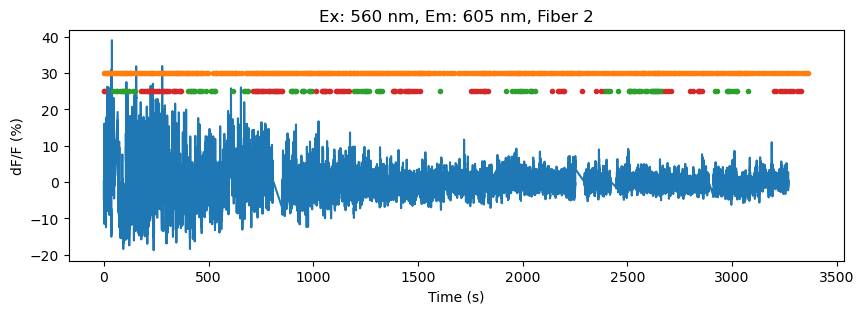

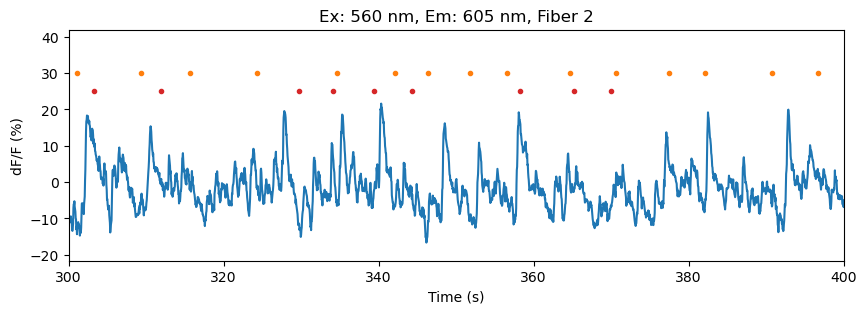

In [31]:
# Plot check for harp triggers and 560 nm signal in time

# Detrent the signal with a 4th order polynomial
def detrend_signal(signal):
    x = np.arange(len(signal))
    p = np.polyfit(x,signal,4)
    y = np.polyval(p,x)
    signal_detrended = signal - y + np.mean(signal)
    return signal_detrended

px = 605
detrended_signal = detrend_signal(L_560_F2[:,px-400])

# Calculate deltaF/F for 560 nm signal
dF_F = 100*(detrended_signal-np.mean(detrended_signal))/np.mean(detrended_signal)

plt.figure(figsize=(10,3))
plt.plot(harp_time_560-harp_time_560[0],dF_F)
t = np.array(data['B_GoCueTimeHarp'])
plt.plot(t-t[0],30*np.ones(len(data['B_GoCueTimeHarp'])),'.')
t = np.array(data['B_LeftRewardDeliveryTimeHarp'])
plt.plot(t-t[0],25*np.ones(len(data['B_LeftRewardDeliveryTimeHarp'])),'.')
t = np.array(data['B_RightRewardDeliveryTimeHarp'])
plt.plot(t-t[0],25*np.ones(len(data['B_RightRewardDeliveryTimeHarp'])),'.')
plt.xlabel('Time (s)')
plt.ylabel('dF/F (%)')
plt.title('Ex: 560 nm, Em: 605 nm, Fiber 2')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(harp_time_560-harp_time_560[0],dF_F)
t = np.array(data['B_GoCueTimeHarp'])
plt.plot(t-t[0],30*np.ones(len(data['B_GoCueTimeHarp'])),'.')
t = np.array(data['B_LeftRewardDeliveryTimeHarp'])
plt.plot(t-t[0],25*np.ones(len(data['B_LeftRewardDeliveryTimeHarp'])),'.')
t = np.array(data['B_RightRewardDeliveryTimeHarp'])
plt.plot(t-t[0],25*np.ones(len(data['B_RightRewardDeliveryTimeHarp'])),'.')
plt.xlim(300,400)
plt.xlabel('Time (s)')
plt.ylabel('dF/F (%)')
plt.title('Ex: 560 nm, Em: 605 nm, Fiber 2')
plt.show()


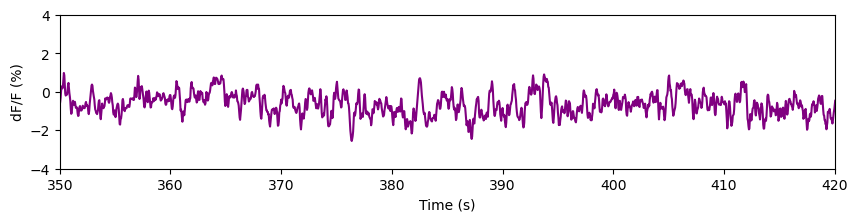

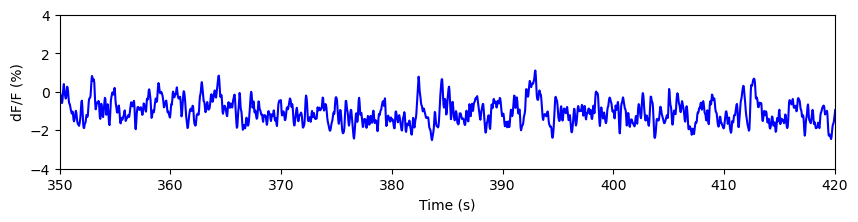

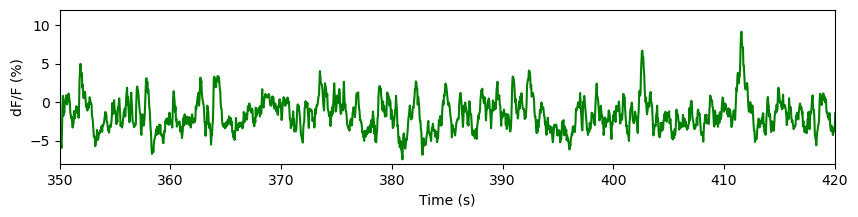

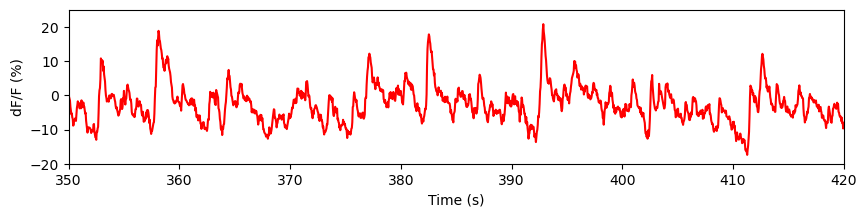

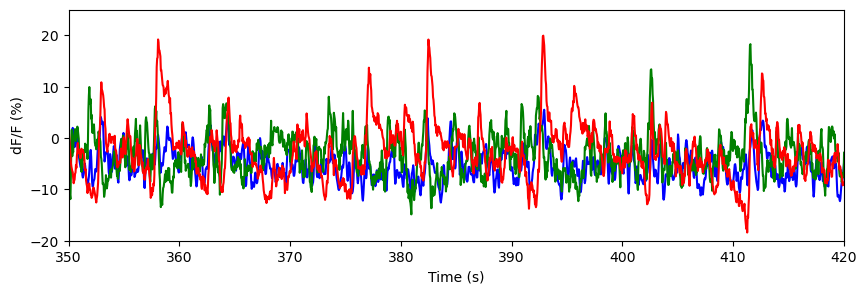

In [25]:
# Plot specific wavelength time trace for each excitation laser

# Detrent the signal with a 4th order polynomial
def detrend_signal(signal,time,color,ylim):
    x = np.arange(len(signal))
    p = np.polyfit(x,signal,4)
    y = np.polyval(p,x)
    signal_detrended = signal - y + np.mean(signal)
    dF_F = 100*(signal_detrended-np.mean(signal_detrended))/np.mean(signal_detrended)
    plt.figure(figsize=(10,2))
    plt.plot(time,dF_F,color=color)
    plt.xlabel('Time (s)')
    plt.ylabel('dF/F (%)')
    plt.xlim([350,420])
    plt.ylim(ylim)
    plt.show()
    return 


px = 500
detrend_signal(L_445_F2[:,px-400],harp_time_445-harp_time_445[0],'purple',[-4,4])
px = 510
detrend_signal(L_473_F2[:,px-400],harp_time_473-harp_time_473[0],'blue',[-4,4])
px = 540
detrend_signal(L_514_F2[:,px-400],harp_time_514-harp_time_514[0],'green',[-8,12])
px = 610
detrend_signal(L_560_F2[:,px-400],harp_time_560-harp_time_560[0],'red',[-20,25])


def detrend_signal(signal):
    x = np.arange(len(signal))
    p = np.polyfit(x,signal,4)
    y = np.polyval(p,x)
    signal_detrended = signal - y + np.mean(signal)
    dF_F = 100*(signal_detrended-np.mean(signal_detrended))/np.mean(signal_detrended)
    return dF_F

px = 510
dF_F_473 = detrend_signal(L_473_F2[:,px-400])
px = 540
dF_F_514 = detrend_signal(L_514_F2[:,px-400])
px = 605
dF_F_560 = detrend_signal(L_560_F2[:,px-400])
# Plot overlapping traces
plt.figure(figsize=(10,3))
plt.plot(harp_time_473-harp_time_473[0],5*dF_F_473,'b')
plt.plot(harp_time_514-harp_time_514[0],2*dF_F_514,'g')
plt.plot(harp_time_560-harp_time_560[0],dF_F_560,'r')
plt.xlabel('Time (s)')
plt.ylabel('dF/F (%)')
plt.xlim([350,420])
plt.ylim([-20,25])
plt.show()



In [26]:
# Detrent the hsfp data with a 4th order polynomial

def detrend_signal(signal):
    x = np.arange(len(signal))
    p = np.polyfit(x,signal,4)
    y = np.polyval(p,x)
    signal_detrended = signal - y + np.mean(signal)
    return signal_detrended

L_405_F1_detrend = np.zeros(np.shape(L_405_F1))
L_405_F2_detrend = np.zeros(np.shape(L_405_F2))
L_445_F1_detrend = np.zeros(np.shape(L_445_F1))
L_445_F2_detrend = np.zeros(np.shape(L_445_F2))
L_473_F1_detrend = np.zeros(np.shape(L_473_F1))
L_473_F2_detrend = np.zeros(np.shape(L_473_F2))
L_514_F1_detrend = np.zeros(np.shape(L_514_F1))
L_514_F2_detrend = np.zeros(np.shape(L_514_F2))
L_560_F1_detrend = np.zeros(np.shape(L_560_F1))
L_560_F2_detrend = np.zeros(np.shape(L_560_F2))
for i in range(len(L_560_F2[0,:])):
    L_405_F1_detrend[:,i] = detrend_signal(L_405_F1[:,i])
    L_405_F2_detrend[:,i] = detrend_signal(L_405_F2[:,i])
    L_445_F1_detrend[:,i] = detrend_signal(L_445_F1[:,i])
    L_445_F2_detrend[:,i] = detrend_signal(L_445_F2[:,i])
    L_473_F1_detrend[:,i] = detrend_signal(L_473_F1[:,i])
    L_473_F2_detrend[:,i] = detrend_signal(L_473_F2[:,i])
    L_514_F1_detrend[:,i] = detrend_signal(L_514_F1[:,i])
    L_514_F2_detrend[:,i] = detrend_signal(L_514_F2[:,i])
    L_560_F1_detrend[:,i] = detrend_signal(L_560_F1[:,i])
    L_560_F2_detrend[:,i] = detrend_signal(L_560_F2[:,i])

# Calculate deltaF/F for each detrended trace
dF_F_405_F1 = ((L_405_F1_detrend/np.mean(L_405_F1_detrend,axis=0))-1)*100
dF_F_405_F2 = ((L_405_F2_detrend/np.mean(L_405_F2_detrend,axis=0))-1)*100
dF_F_445_F1 = ((L_445_F1_detrend/np.mean(L_445_F1_detrend,axis=0))-1)*100
dF_F_445_F2 = ((L_445_F2_detrend/np.mean(L_445_F2_detrend,axis=0))-1)*100
dF_F_473_F1 = ((L_473_F1_detrend/np.mean(L_473_F1_detrend,axis=0))-1)*100
dF_F_473_F2 = ((L_473_F2_detrend/np.mean(L_473_F2_detrend,axis=0))-1)*100
dF_F_514_F1 = ((L_514_F1_detrend/np.mean(L_514_F1_detrend,axis=0))-1)*100
dF_F_514_F2 = ((L_514_F2_detrend/np.mean(L_514_F2_detrend,axis=0))-1)*100
dF_F_560_F1 = ((L_560_F1_detrend/np.mean(L_560_F1_detrend,axis=0))-1)*100
dF_F_560_F2 = ((L_560_F2_detrend/np.mean(L_560_F2_detrend,axis=0))-1)*100


Text(0.5, 1.0, 'Ex: 560 nm, Fiber 2')

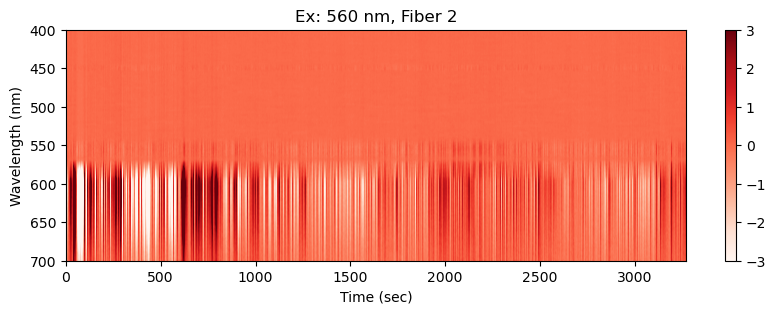

In [28]:
# Plot spectrogram of wavelength over time

plt.figure(figsize=(10,3))
t = harp_time_560-harp_time_560[0]
plt.imshow(np.transpose(dF_F_560_F2),aspect='auto',cmap='Reds',vmin=-3,vmax=3,extent=[t[0],t[-1],700,400])
plt.colorbar()
plt.xlabel('Time (sec)')
plt.ylabel('Wavelength (nm)')
plt.title('Ex: 560 nm, Fiber 2')

In [ ]:
# Align traces to cue onset and create matrix of rewarded and unrewrded trials

cueTrigger = data['B_GoCueTime']
freq = 120/5
timestep = 1/freq
t = np.arange(0,10,timestep)

trials = []
count = 0
L_405_F1_cue = np.zeros((2*len(t),len(L_405_F1[0,:]),len(cueTrigger)))
L_405_F2_cue = np.zeros((2*len(t),len(L_405_F2[0,:]),len(cueTrigger)))
L_445_F1_cue = np.zeros((2*len(t),len(L_445_F1[0,:]),len(cueTrigger)))
L_445_F2_cue = np.zeros((2*len(t),len(L_445_F2[0,:]),len(cueTrigger)))
L_473_F1_cue = np.zeros((2*len(t),len(L_473_F1[0,:]),len(cueTrigger)))
L_473_F2_cue = np.zeros((2*len(t),len(L_473_F2[0,:]),len(cueTrigger)))
L_514_F1_cue = np.zeros((2*len(t),len(L_514_F1[0,:]),len(cueTrigger)))
L_514_F2_cue = np.zeros((2*len(t),len(L_514_F2[0,:]),len(cueTrigger)))
L_560_F1_cue = np.zeros((2*len(t),len(L_560_F1[0,:]),len(cueTrigger)))
L_560_F2_cue = np.zeros((2*len(t),len(L_560_F2[0,:]),len(cueTrigger)))
for i in range(len(cueTrigger)):
    min_time = np.min(abs(cueTrigger[i]-full_harp_time))
    if min_time < 0.005:
        id = np.where(abs(cueTrigger[i]-full_harp_time) == min_time)
        if np.min(abs(id[0][0]-peaks_hsfp)) > 2*len(t) and id[0][0] > 2*len(t) and id[0][0] < len(full_harp_time)-10*len(t):
            idx = np.where((np.abs(harp_time_405 - cueTrigger[i])) == np.min(np.abs(harp_time_405 - cueTrigger[i])))[0][0]
            if idx > len(t):
                L_405_F1_cue[:,:,count] = dF_F_405_F1[idx-len(t):idx+len(t),:]
                L_405_F2_cue[:,:,count] = dF_F_405_F2[idx-len(t):idx+len(t),:]
                L_445_F1_cue[:,:,count] = dF_F_445_F1[idx-len(t):idx+len(t),:]
                L_445_F2_cue[:,:,count] = dF_F_445_F2[idx-len(t):idx+len(t),:]
                L_473_F1_cue[:,:,count] = dF_F_473_F1[idx-len(t):idx+len(t),:]
                L_473_F2_cue[:,:,count] = dF_F_473_F2[idx-len(t):idx+len(t),:]
                L_514_F1_cue[:,:,count] = dF_F_514_F1[idx-len(t):idx+len(t),:]
                L_514_F2_cue[:,:,count] = dF_F_514_F2[idx-len(t):idx+len(t),:]
                L_560_F1_cue[:,:,count] = dF_F_560_F1[idx-len(t):idx+len(t),:]
                L_560_F2_cue[:,:,count] = dF_F_560_F2[idx-len(t):idx+len(t),:]    
                trials.append(i)
                count = count+1    
L_405_F1_cue = L_405_F1_cue[:,:,:count]
L_405_F2_cue = L_405_F2_cue[:,:,:count]
L_445_F1_cue = L_445_F1_cue[:,:,:count]
L_445_F2_cue = L_445_F2_cue[:,:,:count]
L_473_F1_cue = L_473_F1_cue[:,:,:count]
L_473_F2_cue = L_473_F2_cue[:,:,:count]
L_514_F1_cue = L_514_F1_cue[:,:,:count]
L_514_F2_cue = L_514_F2_cue[:,:,:count]
L_560_F1_cue = L_560_F1_cue[:,:,:count]
L_560_F2_cue = L_560_F2_cue[:,:,:count]

In [ ]:
# Create cue triggered plots of all trials combined

L_405_F1_mCue = np.mean(L_405_F1_cue,axis=2)
L_405_F2_mCue = np.mean(L_405_F2_cue,axis=2)
L_445_F1_mCue = np.mean(L_445_F1_cue,axis=2)
L_445_F2_mCue = np.mean(L_445_F2_cue,axis=2)
L_473_F1_mCue = np.mean(L_473_F1_cue,axis=2)
L_473_F2_mCue = np.mean(L_473_F2_cue,axis=2)
L_514_F1_mCue = np.mean(L_514_F1_cue,axis=2)
L_514_F2_mCue = np.mean(L_514_F2_cue,axis=2)
L_560_F1_mCue = np.mean(L_560_F1_cue,axis=2)
L_560_F2_mCue = np.mean(L_560_F2_cue,axis=2)

time_axis = np.arange(-len(t),len(t))*timestep
px = [490-400, 495-400, 540-400, 600-400]
plt.figure(figsize=(12,5))
plt.subplot(2,5,1)
plt.plot(time_axis,L_405_F1_mCue[:,px[0]])
plt.title('405 nm F1')
plt.subplot(2,5,2)
plt.plot(time_axis,L_445_F1_mCue[:,px[1]])
plt.title('445 nm F1')
plt.subplot(2,5,3)
plt.plot(time_axis,L_473_F1_mCue[:,px[1]])
plt.title('473 nm F1')
plt.subplot(2,5,4)
plt.plot(time_axis,L_514_F1_mCue[:,px[2]])
plt.title('514 nm F1')
plt.subplot(2,5,5)
plt.plot(time_axis,L_560_F1_mCue[:,px[3]])
plt.title('560 nm F1')
plt.subplot(2,5,6)
plt.plot(time_axis,L_405_F2_mCue[:,px[0]])
plt.title('405 nm F2')
plt.subplot(2,5,7)
plt.plot(time_axis,L_445_F2_mCue[:,px[1]])
plt.title('445 nm F2')
plt.subplot(2,5,8)
plt.plot(time_axis,L_473_F2_mCue[:,px[1]])
plt.title('473 nm F2')
plt.subplot(2,5,9)
plt.plot(time_axis,L_514_F2_mCue[:,px[2]])
plt.title('514 nm F2')
plt.subplot(2,5,10)
plt.plot(time_axis,L_560_F2_mCue[:,px[3]])
plt.title('560 nm F2')
plt.show()

In [ ]:
# Seperate trials into rewarded and unrewarded trials and align to choice lick

freq = 120/5
timestep = 1/freq
t = np.arange(0,10,timestep)
cueTrigger = data['B_GoCueTime']
leftLickHistory = np.array(data['B_LeftLickTime'])
rightLickHistory = np.array(data['B_RightLickTime'])
rewardHistory = np.array(data['B_RewardedHistory'])

rw_405_F1 = []
rw_405_F2 = []
rw_445_F1 = []
rw_445_F2 = []
rw_473_F1 = []
rw_473_F2 = []
rw_514_F1 = []
rw_514_F2 = []
rw_560_F1 = []
rw_560_F2 = []
un_405_F1 = []
un_405_F2 = []
un_445_F1 = []
un_445_F2 = []
un_473_F1 = []
un_473_F2 = []
un_514_F1 = []
un_514_F2 = []
un_560_F1 = []
un_560_F2 = []
responseTime = []
save_lick_times = []
rewarded = []
for i in trials:
    cueTriggerTime = cueTrigger[i]
    leftLickTime = leftLickHistory[np.argmax((leftLickHistory - cueTriggerTime)>0)]
    rightLickTime = rightLickHistory[np.argmax((rightLickHistory - cueTriggerTime)>0)]
    firstLickTime = np.min([leftLickTime,rightLickTime])
    rewarded_right = rewardHistory[0,i]
    rewarded_left = rewardHistory[1,i]
    if firstLickTime-cueTriggerTime<4 and firstLickTime-cueTriggerTime>0:
        save_lick_times.append(firstLickTime)
        # check if rewarded_right is true
        if rewarded_right == 1 or rewarded_left == 1:
            rewarded.append(1)
            idx = np.where((np.abs(harp_time_405 - firstLickTime)) == np.min(np.abs(harp_time_405 - firstLickTime)))[0][0]
            rw_405_F1.append(dF_F_405_F1[idx-len(t):idx+len(t),:])
            rw_405_F2.append(dF_F_405_F2[idx-len(t):idx+len(t),:])
            rw_445_F1.append(dF_F_445_F1[idx-len(t):idx+len(t),:])
            rw_445_F2.append(dF_F_445_F2[idx-len(t):idx+len(t),:])
            rw_473_F1.append(dF_F_473_F1[idx-len(t):idx+len(t),:])
            rw_473_F2.append(dF_F_473_F2[idx-len(t):idx+len(t),:])
            rw_514_F1.append(dF_F_514_F1[idx-len(t):idx+len(t),:])
            rw_514_F2.append(dF_F_514_F2[idx-len(t):idx+len(t),:])
            rw_560_F1.append(dF_F_560_F1[idx-len(t):idx+len(t),:])
            rw_560_F2.append(dF_F_560_F2[idx-len(t):idx+len(t),:])
            responseTime.append(firstLickTime-cueTriggerTime)
        elif rewarded_right == 0 and rewarded_left == 0:
            rewarded.append(0)
            idx = np.where((np.abs(harp_time_405 - firstLickTime)) == np.min(np.abs(harp_time_405 - firstLickTime)))[0][0]
            un_405_F1.append(dF_F_405_F1[idx-len(t):idx+len(t),:])
            un_405_F2.append(dF_F_405_F2[idx-len(t):idx+len(t),:])
            un_445_F1.append(dF_F_445_F1[idx-len(t):idx+len(t),:])
            un_445_F2.append(dF_F_445_F2[idx-len(t):idx+len(t),:])
            un_473_F1.append(dF_F_473_F1[idx-len(t):idx+len(t),:])
            un_473_F2.append(dF_F_473_F2[idx-len(t):idx+len(t),:])
            un_514_F1.append(dF_F_514_F1[idx-len(t):idx+len(t),:])
            un_514_F2.append(dF_F_514_F2[idx-len(t):idx+len(t),:])
            un_560_F1.append(dF_F_560_F1[idx-len(t):idx+len(t),:])
            un_560_F2.append(dF_F_560_F2[idx-len(t):idx+len(t),:])
            responseTime.append(firstLickTime-cueTriggerTime)
            responseTime.append(firstLickTime-cueTriggerTime)

rw_405_F1_mlick = np.mean(np.array(rw_405_F1),axis=0)
rw_405_F2_mlick = np.mean(np.array(rw_405_F2),axis=0)
rw_445_F1_mlick = np.mean(np.array(rw_445_F1),axis=0)
rw_445_F2_mlick = np.mean(np.array(rw_445_F2),axis=0)
rw_473_F1_mlick = np.mean(np.array(rw_473_F1),axis=0)
rw_473_F2_mlick = np.mean(np.array(rw_473_F2),axis=0)
rw_514_F1_mlick = np.mean(np.array(rw_514_F1),axis=0)
rw_514_F2_mlick = np.mean(np.array(rw_514_F2),axis=0)
rw_560_F1_mlick = np.mean(np.array(rw_560_F1),axis=0)
rw_560_F2_mlick = np.mean(np.array(rw_560_F2),axis=0)
un_405_F1_mlick = np.mean(np.array(un_405_F1),axis=0)
un_405_F2_mlick = np.mean(np.array(un_405_F2),axis=0)
un_445_F1_mlick = np.mean(np.array(un_445_F1),axis=0)
un_445_F2_mlick = np.mean(np.array(un_445_F2),axis=0)
un_473_F1_mlick = np.mean(np.array(un_473_F1),axis=0)
un_473_F2_mlick = np.mean(np.array(un_473_F2),axis=0)
un_514_F1_mlick = np.mean(np.array(un_514_F1),axis=0)
un_514_F2_mlick = np.mean(np.array(un_514_F2),axis=0)
un_560_F1_mlick = np.mean(np.array(un_560_F1),axis=0)
un_560_F2_mlick = np.mean(np.array(un_560_F2),axis=0)


In [ ]:
# Get the lick times in hsfp time

lick_times = []
index = []
idx = []
for i in save_lick_times:
    idx = np.where((np.abs(harp_time_405 - i)) == np.min(np.abs(harp_time_405 - i)))[0][0]
    index.append(idx)
    lick_times.append(time_405[idx])

# Save lick times as csv
lick_times = np.array(lick_times)
lick_times = lick_times.reshape(len(lick_times),1)
lick_times = pd.DataFrame(lick_times)
rewarded = np.array(rewarded)
rewarded = rewarded.reshape(len(rewarded),1)
rewarded = pd.DataFrame(rewarded)
# Concatenate lick_times with rewarded
lick_times_new = pd.concat([lick_times,rewarded],axis=1)
lick_times_new.to_csv(paths['raw_data'] / 'lick_times.csv',index=False)


In [ ]:
# Plot histogram of response times
plt.figure(figsize=(8,3))
plt.hist(responseTime,bins=100)
plt.xlabel('Response time (s)')
plt.show()


In [ ]:
# Create ten subplots of line plots of all trials combined for each laser at the choice lick for rewarded and unrewarded trials

time_axis = np.arange(-len(t),len(t))*timestep
px = [530-400, 525-400, 540-400, 605-400]
plt.figure(figsize=(15,6))
plt.subplot(2,5,1)
plt.plot(time_axis,rw_405_F1_mlick[:,px[0]])
plt.plot(time_axis,un_405_F1_mlick[:,px[0]])
plt.title('F1: Ex: 405 & Em: 530')
plt.legend(['rewarded','unrewarded'])
plt.subplot(2,5,2)
plt.plot(time_axis,rw_445_F1_mlick[:,px[1]])
plt.plot(time_axis,un_445_F1_mlick[:,px[1]])
plt.title('F1: Ex: 445 & Em: 495')
#plt.legend(['rewarded','unrewarded'])
plt.subplot(2,5,3)
plt.plot(time_axis,rw_473_F1_mlick[:,px[1]])
plt.plot(time_axis,un_473_F1_mlick[:,px[1]])
plt.title('F1: Ex: 473 & Em: 495')
#plt.legend(['rewarded','unrewarded'])
plt.subplot(2,5,4)
plt.plot(time_axis,rw_514_F1_mlick[:,px[2]])
plt.plot(time_axis,un_514_F1_mlick[:,px[2]])
plt.title('F1: Ex: 514 & Em: 540')
#plt.legend(['rewarded','unrewarded'])
plt.subplot(2,5,5)
plt.plot(time_axis,rw_560_F1_mlick[:,px[3]])
plt.plot(time_axis,un_560_F1_mlick[:,px[3]])
plt.title('F1: Ex: 560 & Em: 595')
#plt.legend(['rewarded','unrewarded'])

plt.subplot(2,5,6)
plt.plot(time_axis,rw_405_F2_mlick[:,px[0]])
plt.plot(time_axis,un_405_F2_mlick[:,px[0]])
plt.title('F2: Ex: 405 & Em: 530')
#plt.legend(['rewarded','unrewarded'])
plt.subplot(2,5,7)
plt.plot(time_axis,rw_445_F2_mlick[:,px[1]])
plt.plot(time_axis,un_445_F2_mlick[:,px[1]])
plt.title('F2: Ex: 445 & Em: 495')
#plt.legend(['rewarded','unrewarded'])
plt.subplot(2,5,8)
plt.plot(time_axis,rw_473_F2_mlick[:,px[1]])
plt.plot(time_axis,un_473_F2_mlick[:,px[1]])
plt.title('F2: Ex: 473 & Em: 540')
#plt.legend(['rewarded','unrewarded'])
plt.subplot(2,5,9)
plt.plot(time_axis,rw_514_F2_mlick[:,px[2]])
plt.plot(time_axis,un_514_F2_mlick[:,px[2]])
plt.title('F2: Ex: 514 & Em: 540')
#plt.legend(['rewarded','unrewarded'])
plt.subplot(2,5,10)
plt.plot(time_axis,rw_560_F2_mlick[:,px[3]])
plt.plot(time_axis,un_560_F2_mlick[:,px[3]])
plt.title('F2: Ex: 560 & Em: 595')
#plt.legend(['rewarded','unrewarded'])
plt.show()


In [ ]:
# Save behavior and photometry aligned signals

data_behaviorHSFP = {'wavelength':wavelength, 'Time':time_axis, 'rw_405_F1':rw_405_F1, 'rw_445_F1':rw_445_F1, 'rw_473_F1':rw_473_F1, 
                        'rw_514_F1':rw_514_F1, 'rw_560_F1':rw_560_F1, 'rw_405_F2':rw_405_F2, 'rw_445_F2':rw_445_F2,
                        'rw_473_F2':rw_473_F2, 'rw_514_F2':rw_514_F2, 'rw_560_F2':rw_560_F2,
                        'unrw_405_F1':un_405_F1, 'unrw_445_F1':un_445_F1, 'unrw_473_F1':un_473_F1,
                        'unrw_514_F1':un_514_F1, 'unrw_560_F1':un_560_F1, 'unrw_405_F2':un_405_F2,
                        'unrw_445_F2':un_445_F2, 'unrw_473_F2':un_473_F2, 'unrw_514_F2':un_514_F2,
                        'unrw_560_F2':un_560_F2}

for key in data_behaviorHSFP.keys():
    print(f'\n{key}')
    print(data_behaviorHSFP[key])

# Write a new hdf5 file with all keys in data_preprocessed
hf = h5py.File(paths['raw_data'] / 'data_behaviorHSFP_noisereg.hdf5','w')
for key in data_behaviorHSFP.keys():
    hf.create_dataset(key, data = data_behaviorHSFP[key])
hf.close()